In [30]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

### GW灰度世界白平衡算法

灰度世界算法（Gray World)是以灰度世界假设为基础的,该假设认为对于一幅有着大量色彩变化的图像, R、 G、 B 三个分量的平均值趋于同一个灰度K。
$$Rgain = k / Ravg $$
$$Ggain = k / Gavg $$
$$Bgain = k / Bavg $$
然后通过k值来求各个通达的增益。
1. 直接给定为固定值, 取其各通道最大值的一半,即取为127或128；
2. 令 K = (Raver+Gaver+Baver)/3,其中Raver,Gaver,Baver分别表示红、 绿、 蓝三个通道的平均值。
算法的第二步是分别计算各通道的增益：
$$k =  (Bavg + Gavg + Ravg)/3$$
3. 设定G通道不变，让R和B通道往G通道上靠，即：
$$Rgain = Rave / Gave$$
$$Bgain = Bave / Gave$$
新的像素的绿色通道不变，红色和蓝色通道通过绿色通道来求

In [31]:
def GW(img):
    '''
    灰度世界假设
    :param img: cv2.imread读取的图片数据
    :return: 返回的白平衡结果图片数据
    '''
    B, G, R = np.double(img[:, :, 0]), np.double(
        img[:, :, 1]), np.double(img[:, :, 2])
    B_ave, G_ave, R_ave = np.mean(B), np.mean(G), np.mean(R)
    K = (B_ave + G_ave + R_ave) / 3
    Kb, Kg, Kr = K / B_ave, K / G_ave, K / R_ave
    print(Kb, Kg, Kr)
    Ba = (B * Kb)
    Ga = (G * Kg)
    Ra = (R * Kr)

    for i in range(len(Ba)):
        for j in range(len(Ba[0])):
            Ba[i][j] = 255 if Ba[i][j] > 255 else Ba[i][j]
            Ga[i][j] = 255 if Ga[i][j] > 255 else Ga[i][j]
            Ra[i][j] = 255 if Ra[i][j] > 255 else Ra[i][j]

    dst_img = np.uint8(np.zeros_like(img))
    dst_img[:, :, 0] = Ba
    dst_img[:, :, 1] = Ga
    dst_img[:, :, 2] = Ra
    return dst_img


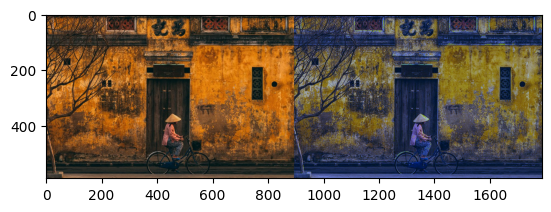

In [32]:

src = cv2.imread('test.jpg')

# 求出各个颜色分量的平均值
b_avg = np.mean(src[:, :, 0])
g_avg = np.mean(src[:, :, 1])
r_avg = np.mean(src[:, :, 2])
# 求出灰度世界的灰度值
k = (b_avg + g_avg + r_avg)/3
# 求出各个颜色分量的增益
b_gain = k / b_avg
g_gain = k / g_avg
r_gain = k / r_avg

# 定义一个新的矩阵存放变换后的图像
src1 = np.zeros(src.shape)
src1[:, :, 0] = src[:, :, 0] * b_gain
src1[:, :, 1] = src[:, :, 1] * g_gain
src1[:, :, 2] = src[:, :, 2] * r_gain

# 计算后类型为浮点数，需要类型转换
src1 = src1.astype(np.uint8)

# 拼接两张图片，便于观察
img = np.hstack([src, src1])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


### WB
图像中最亮的点为白点，那么各个通道的最大值应该趋近白色，可是设定一个K值，如255,那么图像中最两点的值应该趋于255，这样就可以计算出各通道的增益：
$$Rgain = k / Rmax $$
$$Ggain = k / Gmax $$
$$Bgain = k / Bmax $$

In [33]:

def PR(img_input):
    '''
    完美反射白平衡
    STEP 1：计算每个像素的R\G\B之和
    STEP 2：按R+G+B值的大小计算出其前Ratio%的值作为参考点的的阈值T
    STEP 3：对图像中的每个点，计算其中R+G+B值大于T的所有点的R\G\B分量的累积和的平均值
    STEP 4：对每个点将像素量化到[0,255]之间
    依赖ratio值选取而且对亮度最大区域不是白色的图像效果不佳。
    :param img: cv2.imread读取的图片数据
    :return: 返回的白平衡结果图片数据
    '''
    img = img_input.copy()
    b, g, r = cv2.split(img)
    m, n, t = img.shape
    sum_ = np.zeros(b.shape)
    for i in range(m):
        for j in range(n):
            sum_[i][j] = int(b[i][j]) + int(g[i][j]) + int(r[i][j])
    hists, bins = np.histogram(sum_.flatten(), 766, [0, 766])
    Y = 765
    num, key = 0, 0
    ratio = 10
    while Y >= 0:
        num += hists[Y]
        if num > m * n * ratio / 100:
            key = Y
            break
        Y = Y - 1

    mask = sum_ >= key
    sum_b = np.sum(b[mask])
    sum_g = np.sum(g[mask])
    sum_r = np.sum(r[mask])
    time = np.sum(mask)
    avg_b = sum_b / time
    avg_g = sum_g / time
    avg_r = sum_r / time

    maxvalue = float(np.max(img))

    img[:, :, 0] = np.clip((img[:, :, 0] * maxvalue / int(avg_b)), 0, 255)
    img[:, :, 1] = np.clip((img[:, :, 1] * maxvalue / int(avg_g)), 0, 255)
    img[:, :, 2] = np.clip((img[:, :, 2] * maxvalue / int(avg_r)), 0, 255)

    return img


In [34]:
def WB(src):
    # 求出各个颜色分量的增益
    b_gain = 255 / np.max(src[:, :, 0])
    g_gain = 255 / np.max(src[:, :, 1])
    r_gain = 255 / np.max(src[:, :, 2])
# 定义一个新的矩阵存放变换后的图像
    src1 = np.zeros(src.shape)
    src1[:, :, 0] = src[:, :, 0] * b_gain
    src1[:, :, 1] = src[:, :, 1] * g_gain
    src1[:, :, 2] = src[:, :, 2] * r_gain
# 计算后类型为浮点数，需要类型转换
    src1 = src1.astype(np.uint8)
    return src1
    

### QCGP白平衡算法

通过GW和PR两种算法的正交组合，从而保留两者的优点，具体的算法公式如下：
$$ Kave = (Rave + Gave + Bave) / 3 $$
$$ Kmax = (Rmax + Gmax + Bmax) / 3$$
$$ u * Rave^2 + v * Rave = Kave $$
$$ u * Rmax^2 + v* Rmax = Kmax $$
这是R通道的算法公式，求出u和v然后通过以下公式换算出新的值：
$$Rnew = u * Rorg ^ 2 + v * Rorg$$

In [36]:
def QCGP(src):
    src = src.astype(np.uint16)    # 调整一下数据类型，防止算术运算溢出

    # 获取输入图像的高度和宽度
    height, width = src.shape[:2]

    # 求出各个颜色分量的平均值
    b_ave = np.mean(src[:, :, 0])
    g_ave = np.mean(src[:, :, 1])
    r_ave = np.mean(src[:, :, 2])

    # 各个颜色分量的最大值
    b_max = np.max(src[:, :, 0])
    g_max = np.max(src[:, :, 1])
    r_max = np.max(src[:, :, 2])

    # 根据QCGP公式求出系数
    k_ave = (b_ave + g_ave + r_ave) / 3
    k_max = (b_max + g_max + r_max) / 3
    k_matrix = np.mat([[k_ave], [k_max]])

    # 通过矩阵求出B通道的转换矩阵，并计算出新图的B通道
    b_coefficient_matrix = np.mat([[b_ave * b_ave, b_ave],
                                   [b_max * b_max, b_max]])
    b_conversion_matrix = b_coefficient_matrix.I * k_matrix

    b = (src[:, :, 0]).transpose()
    bb = (src[:, :, 0] * src[:, :, 0]).transpose()
    b = np.stack((bb, b), axis=0).transpose()
    b_des = np.dot(b, np.array(b_conversion_matrix))
    b_des = b_des.astype(np.uint8).reshape([height, width])

    # 通过矩阵求出G通道的转换矩阵，并计算出新图的G通道
    g_coefficient_matrix = np.mat([[g_ave * g_ave, g_ave],
                                   [g_max * g_max, g_max]])
    g_conversion_matrix = g_coefficient_matrix.I * k_matrix

    g = (src[:, :, 1]).transpose()
    gg = (src[:, :, 1] * src[:, :, 1]).transpose()
    g = np.stack((gg, g), axis=0).transpose()
    g_des = np.dot(g, np.array(g_conversion_matrix))
    g_des = g_des.astype(np.uint8).reshape([height, width])

    # 通过矩阵求出R通道的转换矩阵，并计算出新图的R通道
    r_coefficient_matrix = np.mat([[r_ave * r_ave, r_ave],
                                   [r_max * r_max, r_max]])
    r_conversion_matrix = r_coefficient_matrix.I * k_matrix

    r = (src[:, :, 2]).transpose()
    rr = (src[:, :, 2] * src[:, :, 2]).transpose()
    r = np.stack((rr, r), axis=0).transpose()
    r_des = np.dot(r, np.array(r_conversion_matrix))
    r_des = r_des.astype(np.uint8).reshape([height, width])

    # 用一个新的矩阵接受新的图片，注意数据类型要和原图一致
    src1 = np.zeros(src.shape).astype(np.uint8)
    src1[:, :, 0] = b_des
    src1[:, :, 1] = g_des
    src1[:, :, 2] = r_des
    return src1


In [37]:
def Dynamic_Threshold(img):
    b, g, r = cv2.split(img)
    def con_num(x):
        if x > 0:
            return 1
        if x < 0:
            return -1
        if x == 0:
            return 0
    yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    (y, u, v) = cv2.split(yuv_img)
    m, n = y.shape
    sum_u, sum_v = 0, 0
    max_y = np.max(y.flatten())
    # print(max_y)
    for i in range(m):
        for j in range(n):
            sum_u = sum_u + u[i][j]
            sum_v = sum_v + v[i][j]

    avl_u = sum_u / (m * n)
    avl_v = sum_v / (m * n)
    du, dv = 0, 0
    # print(avl_u, avl_v)
    for i in range(m):
        for j in range(n):
            du = du + np.abs(u[i][j] - avl_u)
            dv = dv + np.abs(v[i][j] - avl_v)

    avl_du = du / (m * n)
    avl_dv = dv / (m * n)
    num_y, yhistogram, ysum = np.zeros(y.shape), np.zeros(256), 0
    radio = 0.5  # 如果该值过大过小，色温向两极端发展
    for i in range(m):
        for j in range(n):
            value = 0
            if np.abs(u[i][j] - (avl_u + avl_du * con_num(avl_u))) < radio * avl_du or np.abs(
                    v[i][j] - (avl_v + avl_dv * con_num(avl_v))) < radio * avl_dv:
                value = 1
            else:
                value = 0

            if value <= 0:
                continue
            num_y[i][j] = y[i][j]
            yhistogram[int(num_y[i][j])] = 1 + yhistogram[int(num_y[i][j])]
            ysum += 1
    # print(yhistogram.shape)
    sum_yhistogram = 0
    # hists2, bins = np.histogram(yhistogram, 256, [0, 256])
    # print(hists2)
    Y = 255
    num, key = 0, 0
    while Y >= 0:
        num += yhistogram[Y]
        if num > 0.1 * ysum:    # 取前10%的亮点为计算值，如果该值过大易过曝光，该值过小调整幅度小
            key = Y
            break
        Y = Y - 1
    # print(key)
    sum_r, sum_g, sum_b, num_rgb = 0, 0, 0, 0
    for i in range(m):
        for j in range(n):
            if num_y[i][j] > key:
                sum_r = sum_r + r[i][j]
                sum_g = sum_g + g[i][j]
                sum_b = sum_b + b[i][j]
                num_rgb += 1

    avl_r = sum_r / num_rgb
    avl_g = sum_g / num_rgb
    avl_b = sum_b / num_rgb

    for i in range(m):
        for j in range(n):
            b_point = int(b[i][j]) * int(max_y) / avl_b
            g_point = int(g[i][j]) * int(max_y) / avl_g
            r_point = int(r[i][j]) * int(max_y) / avl_r
            if b_point > 255:
                b[i][j] = 255
            else:
                if b_point < 0:
                    b[i][j] = 0
                else:
                    b[i][j] = b_point
            if g_point > 255:
                g[i][j] = 255
            else:
                if g_point < 0:
                    g[i][j] = 0
                else:
                    g[i][j] = g_point
            if r_point > 255:
                r[i][j] = 255
            else:
                if r_point < 0:
                    r[i][j] = 0
                else:
                    r[i][j] = r_point

    return cv2.merge([b, g, r])



    基于图像分析的偏色检测及颜色校正方法
    :param img: cv2.imread读取的图片数据
    :return: 返回的白平衡结果图片数据


In [38]:

def analyze(img):
    b, g, r = cv2.split(img)
    m, n = b.shape

    I_r_2 = np.zeros(r.shape)
    I_b_2 = np.zeros(b.shape)
    sum_I_r_2, sum_I_r, sum_I_b_2, sum_I_b, sum_I_g = 0, 0, 0, 0, 0
    for i in range(m):
        for j in range(n):
            I_r_2[i][j] = int(r[i][j] ** 2)
            I_b_2[i][j] = int(b[i][j] ** 2)
            sum_I_r_2 = I_r_2[i][j] + sum_I_r_2
            sum_I_b_2 = I_b_2[i][j] + sum_I_b_2
            sum_I_g = g[i][j] + sum_I_g
            sum_I_r = r[i][j] + sum_I_r
            sum_I_b = b[i][j] + sum_I_b

    max_I_r = np.max(r)
    max_I_r_2 = np.max(I_r_2)
    max_I_g = np.max(g)
    max_I_b_2 = np.max(I_b_2)
    max_I_b = np.max(b)
    [u_b, v_b] = np.matmul(np.linalg.inv(
        [[sum_I_b_2, sum_I_b], [max_I_b_2, max_I_b]]), [sum_I_g, max_I_g])
    [u_r, v_r] = np.matmul(np.linalg.inv(
        [[sum_I_r_2, sum_I_r], [max_I_r_2, max_I_r]]), [sum_I_g, max_I_g])
    # print(u_b, v_b, u_r, v_r)

    b_point = u_b * I_b_2 + v_b * b
    r_point = u_r * I_r_2 + v_r * r

    r0 = np.clip(r_point, 0, 255).astype(np.uint8)
    b0 = np.clip(b_point, 0, 255).astype(np.uint8)
    g0 = g
    return cv2.merge([b0, g0, r0])


测试函数有两个

In [39]:
def white_balance_evaluation1(img):
    """
    白平衡评估函数，计算图像的白平衡调整效果

    参数：
    img: 输入的RGB图像

    返回值：
    white_balance_index: 白平衡调整效果评估指标，数值越小表示效果越好
    """
    def compute_mean_deviation(lab_img):
        # 计算Lab图像中a和b分量的平均偏差
        a_avg = np.mean(lab_img[:, :, 1]) - 128
        b_avg = np.mean(lab_img[:, :, 2])-128
        return a_avg, b_avg

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 计算Lab图像中a和b分量的平均偏差
    mean_dev_a, mean_dev_b = compute_mean_deviation(lab_img)
    # 计算白平衡调整效果评估指标
    white_balance_index = np.sqrt(mean_dev_a**2 + mean_dev_b**2)
    return white_balance_index


In [40]:
def detection(img):
    '''计算偏色值'''
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    d_a, d_b, M_a, M_b = 0, 0, 0, 0
    d_a = np.mean(a) - 128
    d_b = np.mean(b) - 128
    D = np.sqrt(d_a**2 + d_b**2)

    M_a = np.mean(np.abs(a - d_a - 128))
    M_b = np.mean(np.abs(b - d_b - 128))
    M = np.sqrt(M_a**2 + M_b**2)
    k = D / M
    return k


测试部分

In [94]:


# 读取原始图片
#img = cv2.imread('NikonD5200_0001_G_AS.png')
img = cv2.imread('woman.png')
# 进行白平衡处理
img1 = GW(img)
img2 = WB(img)
img3 = PR(img)
img4 = QCGP(img)
img5 = Dynamic_Threshold(img)
img6 = analyze(img)


2.785465092892772 1.0458989236056155 0.5935147153022998


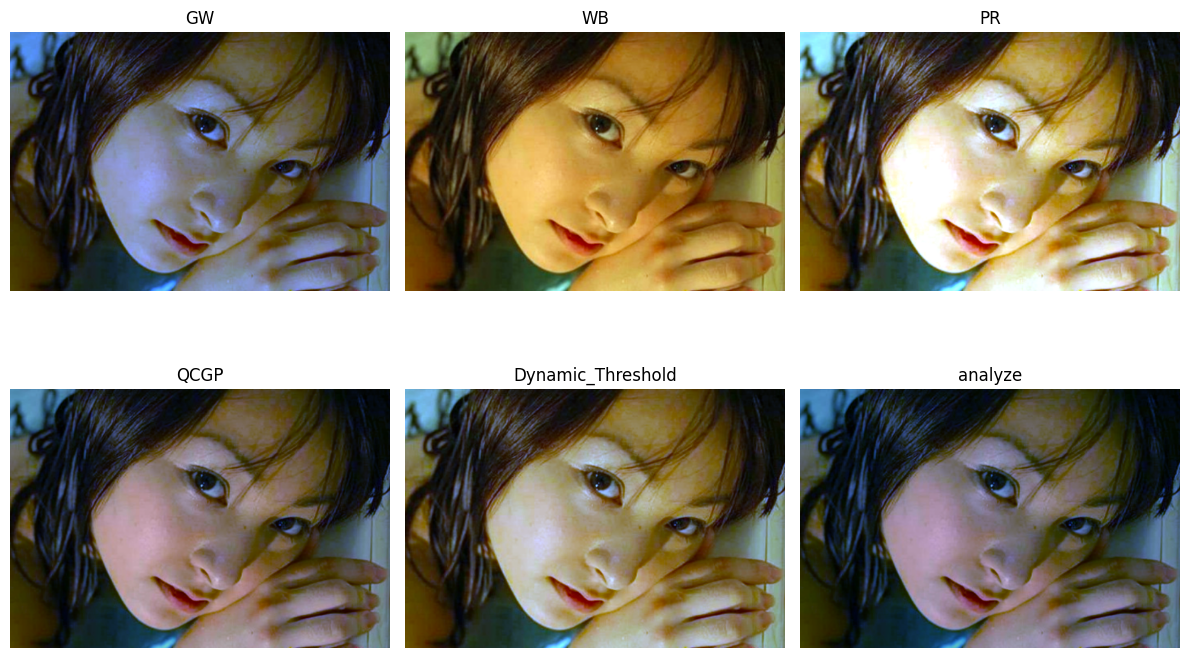

In [95]:

# Create a subplot grid to display the images
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot each image in a separate subplot
axs[0, 0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('GW')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('WB')
axs[0, 1].axis('off')

axs[0, 2].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('PR')
axs[0, 2].axis('off')

axs[1, 0].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('QCGP')
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Dynamic_Threshold')
axs[1, 1].axis('off')

axs[1, 2].imshow(cv2.cvtColor(img6, cv2.COLOR_BGR2RGB))
axs[1, 2].set_title('analyze')
axs[1, 2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged image with all the processed images
plt.show()


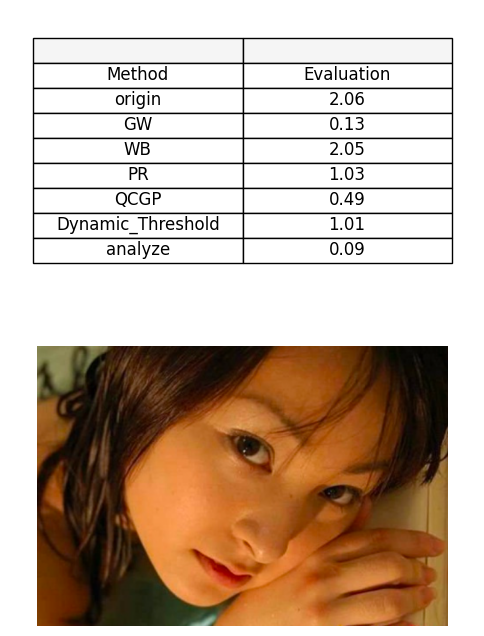

In [96]:
# 计算白平衡评估指标
value1 = detection(img)
value2 = detection(img1)
value3 = detection(img2)
value4 = detection(img3)
value5 = detection(img4)
value6 = detection(img5)
value7 = detection(img6)
white_balance_evaluation1 = [value1, value2,
                             value3, value4, value5, value6, value7]

# 创建表格数据
table_data = [['Method', 'Evaluation'],
              ['origin', '{:.2f}'.format(white_balance_evaluation1[0])],
              ['GW', '{:.2f}'.format(white_balance_evaluation1[1])],
              ['WB', '{:.2f}'.format(white_balance_evaluation1[2])],
              ['PR', '{:.2f}'.format(white_balance_evaluation1[3])],
              ['QCGP', '{:.2f}'.format(white_balance_evaluation1[4])],
              ['Dynamic_Threshold', '{:.2f}'.format(
                  white_balance_evaluation1[5])],
              ['analyze', '{:.2f}'.format(white_balance_evaluation1[6])]]

# 绘制表格和图片
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].axis('off')
table = ax[0].table(cellText=table_data, cellLoc='center', colColours=[
                    '#f5f5f5'] * 2, colWidths=[0.3, 0.3], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

# 插入图片
ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].axis('off')

plt.show()
